In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import cv2
import tensorflow as tf
from tensorflow.keras.utils import plot_model

import warnings
warnings.filterwarnings("ignore")

2024-02-07 12:57:48.208188: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 12:57:48.208542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 12:57:48.384069: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
metadata = pd.read_excel("/kaggle/input/vqa-rad-visual-question-answering-radiology/VQA_RAD Dataset Public.xlsx")
metadata

,QID_unique,QID_para,QID_linked,IMAGEID_case,IMAGEID,IMAGEORGAN,EVALUATION,QUESTION,Q_REPHASE,Q_RELATION,Q_FRAMED,Q_TYPE,ANSWER,A_TYPE
0,0,freeform,03f451ca-de62-4617-9679-e836026a7642,https://medpix.nlm.nih.gov/case?id=48e1dd0e-85...,https://medpix.nlm.nih.gov/images/full/synpic5...,HEAD,not evaluated,Are regions of the brain infarcted?,NaN,NaN,NaN,PRES,Yes,CLOSED
1,1,freeform,06e26b2c-04b9-42bc-8e98-1de30a0f7682,https://medpix.nlm.nih.gov/case?id=b197277b-69...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,not evaluated,Are the lungs normal appearing?,NaN,NaN,NaN,ABN,No,CLOSED
2,2,freeform,0d0e8b6b-7753-4788-9b6d-dc7f25250c3f,https://medpix.nlm.nih.gov/case?id=b197277b-69...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,not evaluated,Is there evidence of a pneumothorax,NaN,NaN,NaN,PRES,No,CLOSED
3,3,freeform,0e90b6bc-265f-490b-a039-509b9907a3cb,https://medpix.nlm.nih.gov/case?id=19aa8a2b-35...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,given,What type of imaging does this not represent?,NaN,NaN,NaN,MODALITY,ultrasound,OPEN
4,4,freeform,1179f612-12e0-4dda-aee0-f14a5200be7b,https://medpix.nlm.nih.gov/case?id=b197277b-69...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,given,Is this a MRI of the chest?,NaN,NaN,NaN,MODALITY,no,CLOSED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,2243,para,6e01da36-ccda-4462-81c4-c7b5e495fb99,https://medpix.nlm.nih.gov/case?id=5dd90eed-4b...,https://medpix.nlm.nih.gov/images/full/synpic5...,HEAD,evaluated,"Is this image modality T1, T2, or FLAIR?","Is this a T1 weighted, T2 weighted, or FLAIR i...",strict agreement,What is/are the image weighting of the MRI?,MODALITY,FLAIR,CLOSED
2244,2244,freeform,9a4e1869-5c76-4af6-81e4-1864db18bbbe,https://medpix.nlm.nih.gov/case?id=5133d5d4-19...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,evaluated,Is this a PA film?,Is this film taken in a PA modality?,strict agreement,NaN,PLANE,Yes,CLOSED
2245,2245,para,9a4e1869-5c76-4af6-81e4-1864db18bbbe,https://medpix.nlm.nih.gov/case?id=5133d5d4-19...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,evaluated,Is this film taken in a PA modality?,Is this a PA film?,strict agreement,NaN,PLANE,Yes,CLOSED
2246,2246,freeform,e2c3565f-a137-406d-8ab0-de869c86cbee,https://medpix.nlm.nih.gov/case?id=187330b9-9d...,https://medpix.nlm.nih.gov/images/full/synpic3...,ABD,evaluated,What is the hypodensity located inside the ver...,What is the hypo-dense area seen in the verteb...,strict agreement,NaN,PRES,Nucleus Pulposus,OPEN


In [6]:
sampledata = metadata[(metadata["ANSWER"] == "Yes") | (metadata["ANSWER"] == "No") | (metadata["ANSWER"] == "yes") | (metadata["ANSWER"] == "no") ]
sampledata.reset_index(inplace = True, drop = True)
sampledata

,QID_unique,QID_para,QID_linked,IMAGEID_case,IMAGEID,IMAGEORGAN,EVALUATION,QUESTION,Q_REPHASE,Q_RELATION,Q_FRAMED,Q_TYPE,ANSWER,A_TYPE
0,0,freeform,03f451ca-de62-4617-9679-e836026a7642,https://medpix.nlm.nih.gov/case?id=48e1dd0e-85...,https://medpix.nlm.nih.gov/images/full/synpic5...,HEAD,not evaluated,Are regions of the brain infarcted?,NaN,NaN,NaN,PRES,Yes,CLOSED
1,1,freeform,06e26b2c-04b9-42bc-8e98-1de30a0f7682,https://medpix.nlm.nih.gov/case?id=b197277b-69...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,not evaluated,Are the lungs normal appearing?,NaN,NaN,NaN,ABN,No,CLOSED
2,2,freeform,0d0e8b6b-7753-4788-9b6d-dc7f25250c3f,https://medpix.nlm.nih.gov/case?id=b197277b-69...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,not evaluated,Is there evidence of a pneumothorax,NaN,NaN,NaN,PRES,No,CLOSED
3,4,freeform,1179f612-12e0-4dda-aee0-f14a5200be7b,https://medpix.nlm.nih.gov/case?id=b197277b-69...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,given,Is this a MRI of the chest?,NaN,NaN,NaN,MODALITY,no,CLOSED
4,6,freeform,27169439-b749-4b2f-8abe-bfb57a46ce53,https://medpix.nlm.nih.gov/case?id=19aa8a2b-35...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,not evaluated,Is the trachea midline?,NaN,NaN,NaN,PRES,yes,CLOSED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,2236,freeform,2f181109-0890-4447-b2fd-645176ba9aa8,https://medpix.nlm.nih.gov/case?id=693c5942-66...,https://medpix.nlm.nih.gov/images/full/synpic5...,HEAD,evaluated,Is there a midline shift?,Is there structural deviation from the midline?,strict agreement,Is there midline shift?,PRES,No,CLOSED
1188,2237,para,2f181109-0890-4447-b2fd-645176ba9aa8,https://medpix.nlm.nih.gov/case?id=693c5942-66...,https://medpix.nlm.nih.gov/images/full/synpic5...,HEAD,evaluated,Is there structural deviation from the midline?,Is there a midline shift?,strict agreement,Is there midline shift?,PRES,No,CLOSED
1189,2240,freeform,436c2fd7-b598-437a-9d84-ff2778cc8250,https://medpix.nlm.nih.gov/case?id=1aadbdc9-95...,https://medpix.nlm.nih.gov/images/full/synpic3...,CHEST,not evaluated,Is there decreased aeration at the apex?,Is the apical aeration normal or decreased?,not similar,NaN,PRES,Yes,CLOSED
1190,2244,freeform,9a4e1869-5c76-4af6-81e4-1864db18bbbe,https://medpix.nlm.nih.gov/case?id=5133d5d4-19...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,evaluated,Is this a PA film?,Is this film taken in a PA modality?,strict agreement,NaN,PLANE,Yes,CLOSED


In [7]:
labels = np.zeros((len(sampledata),))
for i in range(len(sampledata)):
    if (sampledata["ANSWER"][i] == "Yes") | (sampledata["ANSWER"][i] == "yes"):
        labels[i] = 1
    elif (sampledata["ANSWER"][i] == "No") | (sampledata["ANSWER"][i] == "no"):
        labels[i] = 0
    else:
        labels[i] = None

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

docx = np.array(sampledata["QUESTION"].tolist())
tokenizer = Tokenizer(oov_token = "<nothing>")
tokenizer.fit_on_texts(docx)
sequences = tokenizer.texts_to_sequences(docx)
sequences = pad_sequences(sequences, padding = "post", maxlen = 10)
sequences

array([[  9, 478,   8, ...,   0,   0,   0],
       [  9,   3,  49, ...,   0,   0,   0],
       [  2,   4,  15, ...,   0,   0,   0],
       ...,
       [  2,   4, 458, ...,   0,   0,   0],
       [  2,   5,   7, ...,   0,   0,   0],
       [  2,   5,  82, ..., 203,   0,   0]], dtype=int32)

In [22]:
IMGDIR = "/kaggle/input/vqa-rad-visual-question-answering-radiology/VQA_RAD Image Folder/VQA_RAD Image Folder/"

addresses = []
for i in range(len(sampledata)):
    addresses.append(IMGDIR + sampledata["IMAGEID"][i][39:])
addresses[:10]

['/kaggle/input/vqa-rad-visual-question-answering-radiology/VQA_RAD Image Folder/VQA_RAD Image Folder/synpic54610.jpg',
 '/kaggle/input/vqa-rad-visual-question-answering-radiology/VQA_RAD Image Folder/VQA_RAD Image Folder/synpic29265.jpg',
 '/kaggle/input/vqa-rad-visual-question-answering-radiology/VQA_RAD Image Folder/VQA_RAD Image Folder/synpic29265.jpg',
 '/kaggle/input/vqa-rad-visual-question-answering-radiology/VQA_RAD Image Folder/VQA_RAD Image Folder/synpic29265.jpg',
 '/kaggle/input/vqa-rad-visual-question-answering-radiology/VQA_RAD Image Folder/VQA_RAD Image Folder/synpic28602.jpg',
 '/kaggle/input/vqa-rad-visual-question-answering-radiology/VQA_RAD Image Folder/VQA_RAD Image Folder/synpic28602.jpg',
 '/kaggle/input/vqa-rad-visual-question-answering-radiology/VQA_RAD Image Folder/VQA_RAD Image Folder/synpic28602.jpg',
 '/kaggle/input/vqa-rad-visual-question-answering-radiology/VQA_RAD Image Folder/VQA_RAD Image Folder/synpic42202.jpg',
 '/kaggle/input/vqa-rad-visual-question-

In [23]:
from sklearn.model_selection import train_test_split
train_addresses, val_addresses, ytrain, ytest = train_test_split(addresses, labels, test_size = 0.2, random_state = 42)
train_sequences, val_sequences, ytrain, ytest = train_test_split(sequences, labels, test_size = 0.2, random_state = 42)

In [24]:
def augment_data(tup, label):
    image, sequence = tup
    # Randomly rotate the image (within a range of -20 to 20 degrees)
    angle = tf.random.uniform([], minval=-20, maxval=20, dtype=tf.float32)
    image = tf.image.rot90(image, tf.cast(angle / 90, dtype=tf.int32))

    # Randomly shift the width and height
    shift_x = tf.random.uniform(shape=[], minval=-30, maxval=30, dtype=tf.int32)
    shift_y = tf.random.uniform(shape=[], minval=-30, maxval=30, dtype=tf.int32)
    image = tf.roll(image, shift_x, axis=1)
    image = tf.roll(image, shift_y, axis=0)

    return (image, sequence), label

def process_data(image_path, text_sequence, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (256, 256))
#     image = tf.image.per_image_standardization(image)
    image = tf.cast(image/255, dtype = tf.float32)
    return (image, text_sequence), label

BATCH_SIZE = 32
BUFFER_SIZE = 500

train_data = tf.data.Dataset.from_tensor_slices((train_addresses, train_sequences, ytrain))
val_data = tf.data.Dataset.from_tensor_slices((val_addresses, val_sequences, ytest))

train_data = train_data.map(process_data)
augmented_data = train_data.map(augment_data)
train_data  = train_data.concatenate(augmented_data)

train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.shuffle(buffer_size=BUFFER_SIZE)
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

val_data = val_data.map(process_data)
val_data = val_data.batch(BATCH_SIZE)
val_data = val_data.shuffle(buffer_size=BUFFER_SIZE)
val_data = val_data.prefetch(buffer_size=tf.data.AUTOTUNE)

train_data, val_data

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [25]:
(images, seqs), labs = next(iter(train_data))
images.shape, seqs.shape, labs.shape

(TensorShape([32, 256, 256, 3]), TensorShape([32, 10]), TensorShape([32]))

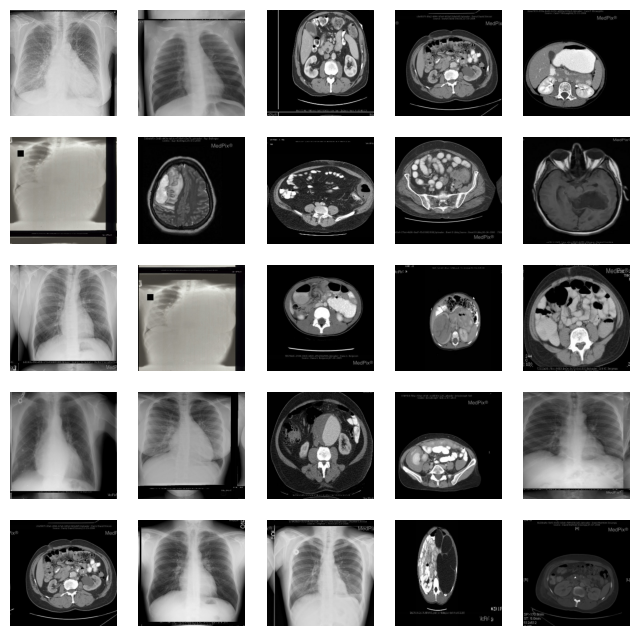

In [28]:
fig, ax = plt.subplots(5,5, figsize = (8, 8))

for i in range(5):
    ax[i][0].imshow(images[i])
    ax[i][0].axis('off')
    ax[i][1].imshow(images[i+5])
    ax[i][1].axis('off')
    ax[i][2].imshow(images[i+10])
    ax[i][2].axis('off')
    ax[i][3].imshow(images[i+15])
    ax[i][3].axis('off')
    ax[i][4].imshow(images[i+20])
    ax[i][4].axis('off')

In [36]:
from transformers import TFBertModel
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, GlobalAveragePooling1D, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model

In [37]:
# Load BERT model and tokenizer

bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Load ResNet model with pre-trained weights
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

# Define image and text inputs
image_input = Input(shape=(256, 256, 3), name='image_input')
text_input = Input(shape=(10,), name='text_input')

# Tokenize the input text
input_ids = tf.cast(text_input, tf.int32)
attention_mask = tf.cast(input_ids != 0, tf.int32)

# Get BERT text embeddings
text_features = bert_model(input_ids, attention_mask=attention_mask)
text_features = text_features.last_hidden_state
text_features = GlobalAveragePooling1D()(text_features)
text_features = Dense(512, activation='relu')(text_features)

# Get ResNet image features
image_features = resnet_model(image_input)
image_features = GlobalAveragePooling2D()(image_features)
image_features = Dense(2048, activation='relu')(image_features)

# Concatenate the image and text feature vectors
merged_features = Concatenate()([image_features, text_features])

# Further model building based on your specific architecture
combined = Dropout(0.2)(merged_features)
combined = Dense(512, activation="relu")(combined)
combined = Dense(256, activation="relu")(combined)
combined = Dense(128, activation="relu")(combined)

# Define the output layer as a separate layer
output_layer = Dense(1, activation='sigmoid', name='output')(combined)

# Define the model with two inputs and one output
model = Model(inputs=[image_input, text_input], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 10)]                 0         []                            
                                                                                                  
 tf.cast (TFOpLambda)        (None, 10)                   0         ['text_input[0][0]']          
                                                                                                  
 tf.__operators__.ne (TFOpL  (None, 10)                   0         ['tf.cast[0][0]']             
 ambda)                                                                                           
                                                                                                  
 image_input (InputLayer)    

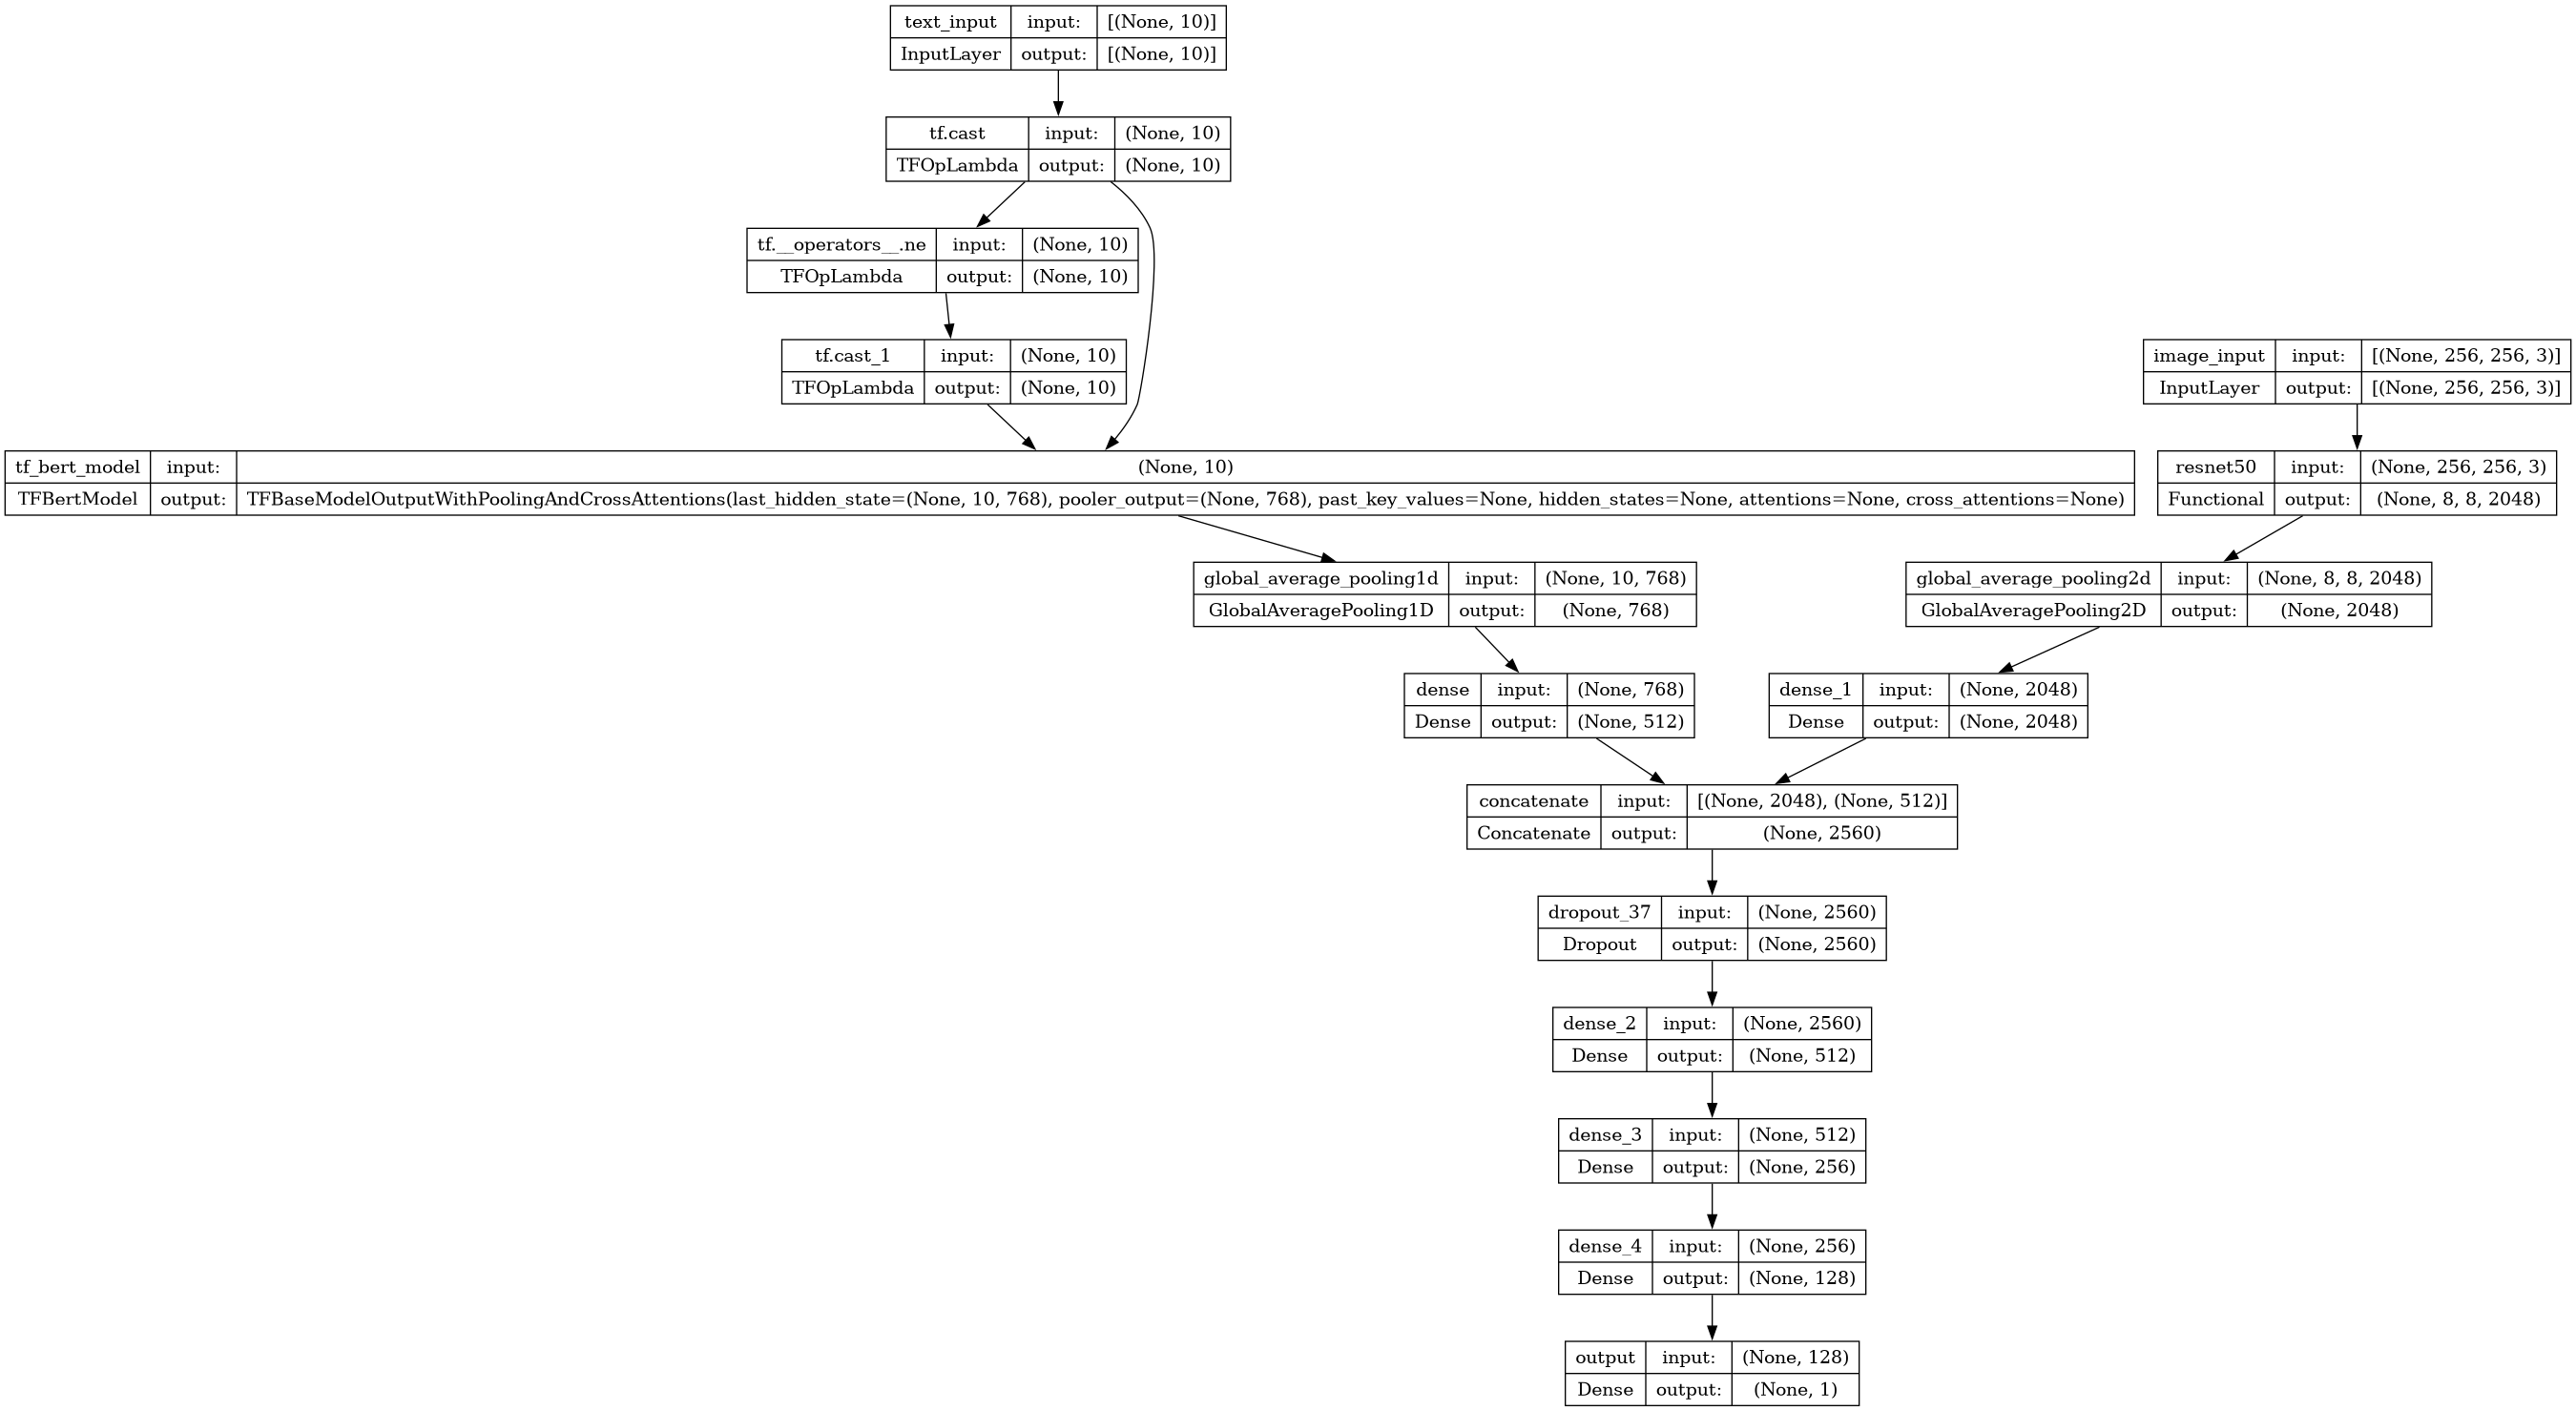

In [38]:
plot_model(model, to_file='model_visualization.png', show_shapes=True, show_layer_names=True)

In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpointer = ModelCheckpoint('/kaggle/working/best.h5',
                                                  verbose=1, save_best_only = True,
                                                monitor='val_loss')

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [43]:
history = model.fit(
    train_data,
    epochs=15, batch_size=16,
    validation_data = val_data,
    callbacks = [checkpointer,earlystopping,learning_rate_reduction])

Epoch 1/15
60/60 [==============================] - ETA: 0s - loss: 0.7234 - accuracy: 0.5021 
Epoch 1: val_loss improved from inf to 20.03700, saving model to /kaggle/working/best.h5
60/60 [==============================] - 1135s 19s/step - loss: 0.7234 - accuracy: 0.5021 - val_loss: 20.0370 - val_accuracy: 0.4895 - lr: 0.0010
Epoch 2/15
60/60 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.5226 
Epoch 2: val_loss improved from 20.03700 to 0.71500, saving model to /kaggle/working/best.h5
60/60 [==============================] - 1122s 19s/step - loss: 0.6938 - accuracy: 0.5226 - val_loss: 0.7150 - val_accuracy: 0.5105 - lr: 0.0010
Epoch 3/15
60/60 [==============================] - ETA: 0s - loss: 0.6946 - accuracy: 0.5168 
Epoch 3: val_loss did not improve from 0.71500
60/60 [==============================] - 1148s 19s/step - loss: 0.6946 - accuracy: 0.5168 - val_loss: 3.6383 - val_accuracy: 0.5105 - lr: 0.0010
Epoch 4/15
60/60 [==============================] 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


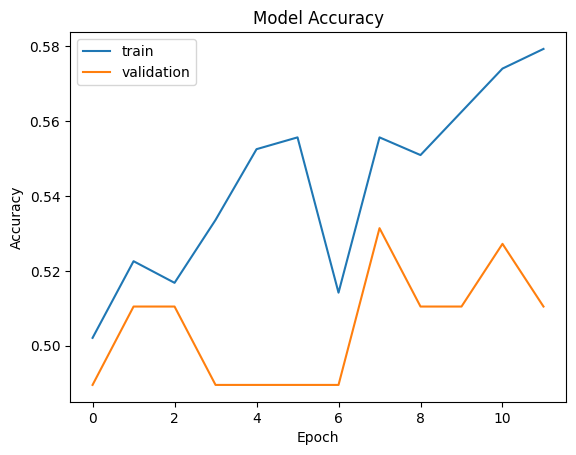

In [45]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

_______________________________________________________________


___________________________________________________________


In [46]:

from tensorflow.keras.layers import Concatenate, Reshape, Dot
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Load BERT model 
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Load ResNet model with pre-trained weights
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

# Define image and text inputs
image_input = Input(shape=(256, 256, 3), name='image_input')
text_input = Input(shape=(10,), name='text_input')

# Tokenize the input text
input_ids = tf.cast(text_input, tf.int32)
attention_mask = tf.cast(input_ids != 0, tf.int32)

# Get BERT text embeddings
text_output = bert_model(input_ids, attention_mask=attention_mask)
text_features = text_output.last_hidden_state
text_features = GlobalAveragePooling1D()(text_features)
text_features = Dense(512, activation='relu')(text_features)

# Get ResNet image features
image_features = resnet_model(image_input)
image_features = GlobalAveragePooling2D()(image_features)
image_features = Dense(512, activation='relu')(image_features)

# Add cross-attention mechanism
text_features_expanded = tf.expand_dims(text_features, axis=1)
text_features_expanded = tf.tile(text_features_expanded, [1, tf.shape(image_features)[1], 1])

image_features_expanded = tf.expand_dims(image_features, axis=1)
image_features_expanded = tf.tile(image_features_expanded, [1, tf.shape(text_features)[1], 1])

image_attention = Dot(axes=[2, 2])([image_features_expanded, text_features_expanded])
text_attention = Dot(axes=[2, 2])([text_features_expanded, image_features_expanded])

image_weighted = tf.multiply(image_features_expanded, image_attention)
text_weighted = tf.multiply(text_features_expanded, text_attention)

# Concatenate the weighted features
final_features = Reshape((-1,))(Concatenate()([image_weighted, text_weighted]))

# Define the rest of the model architecture
merged_features = Dropout(0.2)(final_features)
merged_features = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(merged_features)
merged_features = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(merged_features)
merged_features = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(merged_features)

output_layer = Dense(1, activation='sigmoid', name='output')(merged_features)

# Create the model
model2 = Model(inputs=[image_input, text_input], outputs=output_layer)

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model2.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 10)]                 0         []                            
                                                                                                  
 tf.cast_2 (TFOpLambda)      (None, 10)                   0         ['text_input[0][0]']          
                                                                                                  
 tf.__operators__.ne_1 (TFO  (None, 10)                   0         ['tf.cast_2[0][0]']           
 pLambda)                                                                                         
                                                                                                  
 image_input (InputLayer)    [(None, 256, 256, 3)]        0         []                      

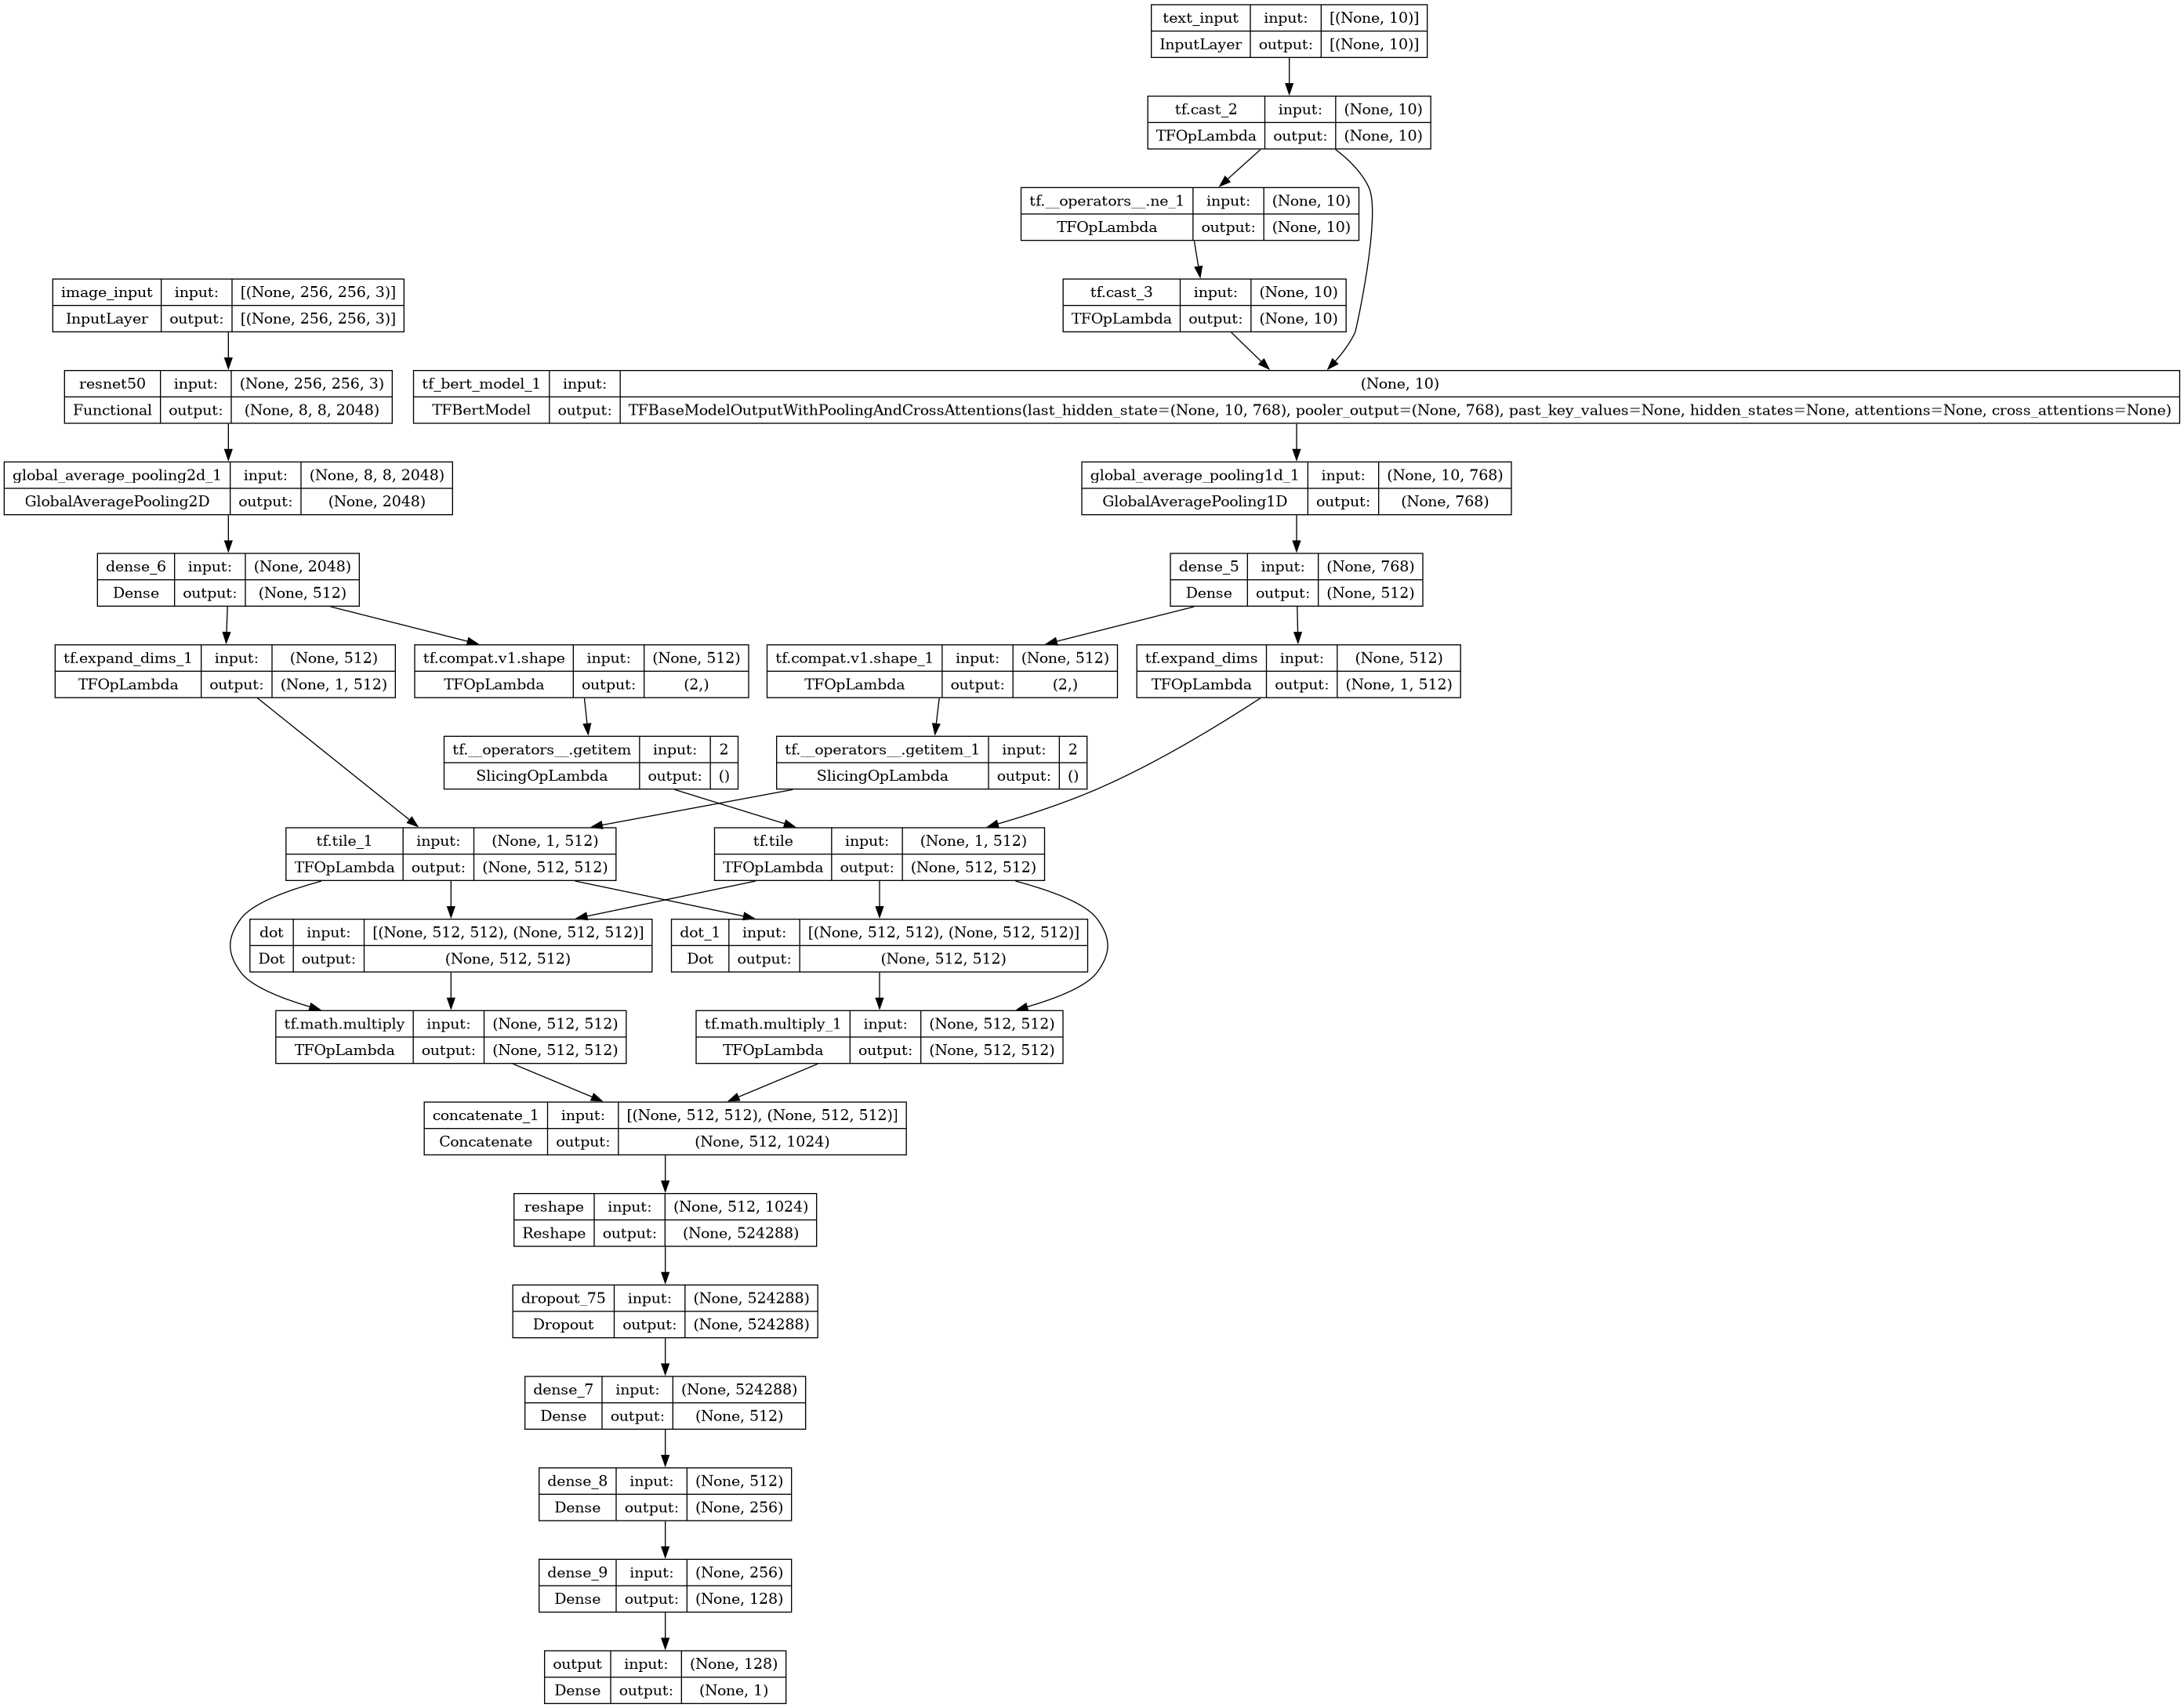

In [47]:
plot_model(model2, to_file='model_visualization.png', show_shapes=True, show_layer_names=True)

In [48]:
checkpointer1 = ModelCheckpoint('/kaggle/working/best2.h5',
                                                  verbose=1, save_best_only = True,
                                                monitor='val_loss')

earlystopping1 = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction1 = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)



In [ ]:
history2 = model2.fit(
    train_data,
    epochs=15, batch_size=16,
    validation_data = val_data,
      callbacks = [checkpointer1,earlystopping1,learning_rate_reduction1]
         )

Epoch 1/15
60/60 [==============================] - ETA: 0s - loss: 152.5372 - accuracy: 0.4916 
Epoch 1: val_loss improved from inf to 58.81491, saving model to /kaggle/working/best2.h5
60/60 [==============================] - 1484s 23s/step - loss: 152.5372 - accuracy: 0.4916 - val_loss: 58.8149 - val_accuracy: 0.5105 - lr: 0.0010
Epoch 2/15
60/60 [==============================] - ETA: 0s - loss: 49.6194 - accuracy: 0.5084 
Epoch 2: val_loss improved from 58.81491 to 41.67482, saving model to /kaggle/working/best2.h5
60/60 [==============================] - 1431s 24s/step - loss: 49.6194 - accuracy: 0.5084 - val_loss: 41.6748 - val_accuracy: 0.5105 - lr: 0.0010
Epoch 3/15
60/60 [==============================] - ETA: 0s - loss: 36.3107 - accuracy: 0.5079 
Epoch 3: val_loss improved from 41.67482 to 31.55928, saving model to /kaggle/working/best2.h5
60/60 [==============================] - 1422s 24s/step - loss: 36.3107 - accuracy: 0.5079 - val_loss: 31.5593 - val_accuracy: 0.5105 - 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


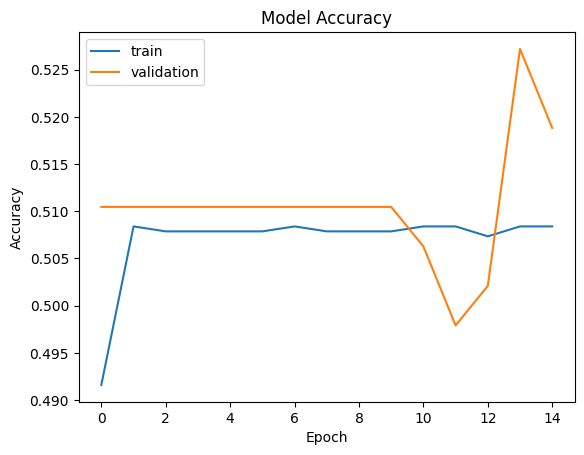

In [51]:
print(history2.history.keys())
#  "Accuracy"
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()